In [525]:
import matplotlib.pyplot as plt 
import numpy as np
from scipy.integrate import solve_ivp

plt.rcParams['figure.figsize'] = [15, 10]


In [480]:
motor_max_torque = 1.1 #N*m, from salto after gearing
motor_max_vel = 25 #rad/s, 825kv motor geared 38.3
motor_I = 0.00000256 #kg*m^2
def get_motor_torque(t, motor_vel):
    input = 0*t + 1 # replace with better function of t
    return motor_max_torque * (input - motor_vel/motor_max_vel)

In [481]:
total_mass = 0.101 #kg
g = 9.81

def jump_model(t, s, k, get_TSA_mult, get_link_mult): #k is spring constant in N/m
    motor_pos, dmotor_pos, foot_pos, dfoot_pos = s #state

    TSA_mult = get_TSA_mult(motor_pos)
    link_mult = get_link_mult(foot_pos)

    spring_pos = -motor_pos/TSA_mult + foot_pos*link_mult

    motor_torque = get_motor_torque(t, dmotor_pos)

    spring_force = -k * spring_pos

    motor_net_torque = motor_torque - spring_force/TSA_mult
    ddmotor_pos = motor_net_torque / motor_I

    foot_applied_force = spring_force*link_mult
    ddfoot_pos = (foot_applied_force - total_mass*g) / total_mass

    if foot_pos <= 0: ddfoot_pos = max(ddfoot_pos, 0)

    return [dmotor_pos, ddmotor_pos, dfoot_pos, ddfoot_pos]

In [482]:
max_extension = 0.15 #m
def liftoff(t, s, k, get_TSA_mult, get_link_mult):
    motor_pos, dmotor_pos, foot_pos, dfoot_pos = s #state

    if foot_pos < max_extension:

        TSA_mult = get_TSA_mult(motor_pos)
        link_mult = get_link_mult(foot_pos)

        spring_pos = -motor_pos/TSA_mult + foot_pos*link_mult

        spring_force = -k * spring_pos

        foot_applied_force = spring_force*link_mult
        foot_net_force = foot_applied_force - total_mass*g
        if foot_pos <= 0: foot_net_force = max(foot_net_force, 0)


        if foot_net_force < 0:
            return 0
        else:
            return 1
    else:
        return 0
liftoff.terminal = True

In [582]:
def solve_end_vel(k, get_TSA_mult, get_link_mult, doPlot):
    t_span = (0, 1)
    s0 = (0, 0, 0, 0)
    solution = solve_ivp(jump_model, t_span, s0, events=[liftoff], args=(k, get_TSA_mult, get_link_mult))

    motor_pos_data = solution.y[0, :]
    motor_vel_data = solution.y[1, :]
    foot_pos_data = solution.y[2, :]
    foot_vel_data = solution.y[3, :]



    if doPlot:
        

        TSA_mult_data = np.vectorize(get_TSA_mult)(motor_pos_data)
        link_mult_data = np.vectorize(get_link_mult)(foot_pos_data)

        spring_pos_data = -motor_pos_data/TSA_mult_data + foot_pos_data*link_mult_data

        plt.figure()
        plt.plot(solution.t, np.zeros_like(solution.t), 'k')

        plt.plot(solution.t, motor_pos_data/max(abs(motor_pos_data)), 'o', markersize=1, label=f"motor_pos {round(max(abs(motor_pos_data)),4)}")
        plt.plot(solution.t, motor_vel_data/max(abs(motor_vel_data)), label=f"motor_vel {round(max(abs(motor_vel_data)),4)}")
        plt.plot(solution.t, np.full(solution.t.shape, motor_max_vel/max(abs(motor_vel_data))), label=f"motor_max_vel")
        plt.plot(solution.t, foot_pos_data/max(abs(foot_pos_data)), label=f"foot_pos {round(max(abs(foot_pos_data)),4)}")
        plt.plot(solution.t, foot_vel_data/max(abs(foot_vel_data)), label=f"foot_vel {round(max(abs(foot_vel_data)),4)}")

        plt.plot(solution.t, TSA_mult_data/max(abs(TSA_mult_data)), '--', label=f"TSA_mult {round(max(abs(TSA_mult_data)),4)}")
        plt.plot(solution.t, link_mult_data/max(abs(link_mult_data)), '--', label=f"link_mult {round(max(abs(link_mult_data)),4)}")
        plt.plot(solution.t, -spring_pos_data/max(abs(spring_pos_data)), label=f"spring_compress {round(max(abs(spring_pos_data)),4)}")

        plt.legend()

        plt.xlabel(f"time(s) {len(solution.t)} samples")
        plt.ylabel("normalized value")
        plt.title(f"k={k}, end_foot_vel={round(foot_vel_data[-1],4)}")

        print('avg motor speed proportion', np.mean(motor_vel_data)/motor_max_vel)

    return foot_vel_data[-1]


avg motor speed proportion 0.501663374401136


2.159754685588309

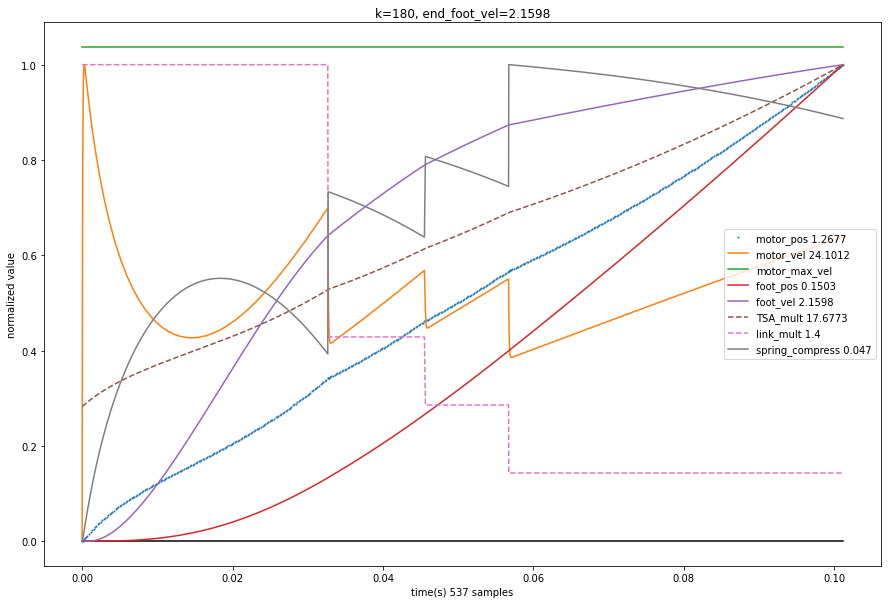

In [585]:
def get_TSA_mult(motor_pos):
    return 5 + 10*motor_pos

def get_link_mult(foot_pos):
    if foot_pos < 0.02:
        return 1.4
    elif foot_pos < 0.04:
        return 0.6
    elif foot_pos < 0.06:
        return 0.4
    else:
        return 0.2
    # return 0.1 + 4*foot_pos

# solve_end_vel(30, get_TSA_mult, get_link_mult, True) 
# solve_end_vel(50, get_TSA_mult, get_link_mult, True) 
# solve_end_vel(70, get_TSA_mult, get_link_mult, True) 
# solve_end_vel(90, get_TSA_mult, get_link_mult, True) 
# solve_end_vel(110, get_TSA_mult, get_link_mult, True) 
solve_end_vel(180, get_TSA_mult, get_link_mult, True) 
# solve_end_vel(300, get_TSA_mult, get_link_mult, True) 


[1.0927356885525066, 1.2273468921675688, 1.338545098333077, 1.4319425829844765, 1.5342806655270913, 1.6457243306516243, 1.7435917327722392, 1.8292043881639553, 1.9035105498261067, 1.9686582462186888, 2.026638394588027, 2.0760386752668083, 2.120616248169725, 2.159754685588309, 2.1939167283882144, 2.2222627024350996, 2.2473561354268003, 2.2692770517307403, 2.2874065323421937, 2.3029043910549802, 2.3143654424558684, 2.3245289907802307, 2.3315283812254717, 2.3369091102988055, 2.3408566702465152]


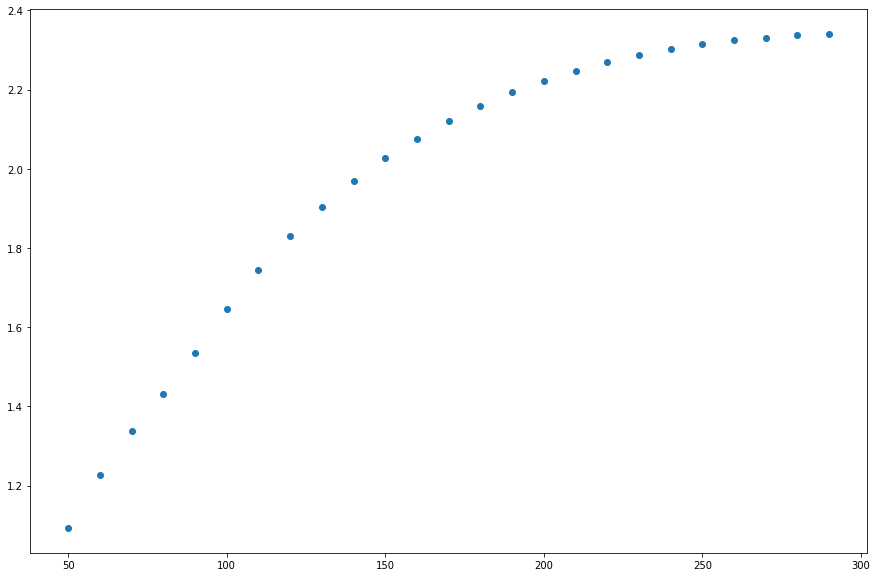

In [579]:
test_ks = np.arange(50, 300, 10)
end_vels = []

for i in test_ks:
    end_vel = solve_end_vel(i, get_TSA_mult, get_link_mult, doPlot=False)
    end_vels.append(end_vel)

print(end_vels)
plt.plot(test_ks, end_vels, 'o')

#TODO: what's the optimal MA profile? make function where input is MA profile and output is max vel (try diff k).